# Kola Market Inventory Recommendation Prototype

Welcome to the **Kola Market Inventory Recommendation Prototype** notebook. This project explores market data for two Ghanaian towns – **Accra** (urban, coastal) and **Tamale** (northern, savannah) – to recommend product categories using a combination of real data simulation, Google Trends analysis, and machine learning.


## Table of Contents

1. [Data Sources & Assumptions](#data-sources--assumptions)
2. [Data Acquisition](#data-acquisition)
   - Demographics & Climate Data
   - Google Trends Data
3. [Data Integration & Product Trends](#data-integration--product-trends)
4. [Visualization of Google Trends](#visualization-of-google-trends)

5. [Machine Learning Approach](#machine-learning-approach)
6. [Market Demand & Data-driven Recommendations](#market-demand--data-driven-recommendations)
7. [Limitations & Suggestions](#limitations--future-extensions)


## 1. Data Sources & Assumptions

- **Demographics:** World Bank Open Data, WorldPop ([https://www.worldpop.org/](https://www.worldpop.org/))
- **Climate:** World Bank Climate Data API ([https://climateknowledgeportal.worldbank.org/country/ghana/climate-data-historical](https://climateknowledgeportal.worldbank.org/country/ghana/climate-data-historical))
- **Market/Product Demand:** Google Trends ([https://trends.google.com/](https://trends.google.com/)), FAO Food Balance Sheets ([https://www.fao.org/faostat/en/#data/FBS](https://www.fao.org/faostat/en/#data/FBS))
- **Assumptions:** The approach uses heuristics based on climate, urbanization, and economic activity.


## 2. Data Acquisition

In the following cells, we load simulated demographic and climate data for Accra and Tamale, and retrieve Google Trends data for selected products.


In [47]:
# Fetch real demographic data for Ghana (Accra and Tamale) from World Bank API or CSV
import pandas as pd
import requests

url = (
    "http://api.worldbank.org/v2/en/country/GH/indicator/SP.POP.TOTL?downloadformat=csv"
)
print("Downloading and extracting the CSV from:", url)

# For demonstration, load a sample population CSV if available locally
df_pop = pd.DataFrame(
    {
        "Region": ["Greater Accra", "Northern"],
        "Population": [5390489, 2562000],  # Example 2021 data
    }
)
df_pop

,Region,Population
0,Greater Accra,5390489
1,Northern,2562000


In [48]:
# Fetch climate data for Ghana (Accra and Tamale) from World Bank Climate Data API
climate_url = (
    "https://climateknowledgeportal.worldbank.org/country/ghana/climate-data-historical"
)
print("Download rainfall/temperature data from:", climate_url)

# For demonstration, load a sample climate DataFrame if available locally
df_climate = pd.DataFrame(
    {
        "Region": ["Greater Accra", "Northern"],
        "Avg_Annual_Rainfall_mm": [800, 1100],
        "Avg_Temp_C": [27.5, 29.0],
        "Rainy_Season": ["May-July", "June-September"],
    }
)
df_climate

Download rainfall/temperature data from: https://climateknowledgeportal.worldbank.org/country/ghana/climate-data-historical


,Region,Avg_Annual_Rainfall_mm,Avg_Temp_C,Rainy_Season
0,Greater Accra,800,27.5,May-July
1,Northern,1100,29.0,June-September


In [49]:
# Fetch Google Trends data for product demand in Ghana using pytrends
from pytrends.request import TrendReq

pytrends = TrendReq(hl="en-US", tz=0)

# products = ["rice", "maize", "canned fish", "cooking oil", "bottled water", "plantain", "yams", "beans"]

products = ["rice", "maize", "canned fish", "cooking oil", "bottled water"]
pytrends.build_payload(products, cat=0, timeframe="today 12-m", geo="GH", gprop="")
trends = pytrends.interest_over_time()
trends = trends[products] if not trends.empty else None
print(
    trends.head()
    if trends is not None
    else "No data returned. Try running this cell with internet access."
)

            rice  maize  canned fish  cooking oil  bottled water
date                                                            
2024-08-04    68     14            0            0              0
2024-08-11   100     14            0            0              0
2024-08-18    67     15            0            0              0
2024-08-25    67     15            0            2              0
2024-09-01    70     16            0            0              0


## 3. Data Integration & Product Trends

We now integrate the acquired data. In this section, we:

- Map regions to towns.
- Aggregate Google Trends data over the last 12 months.
- Create a product trends table that defaults gracefully if no trends data is available.


In [50]:
import numpy as np

# Map regions to towns
region_map = {"Greater Accra": "Accra", "Northern": "Tamale"}
df_pop["Town"] = df_pop["Region"].map(region_map)
df_climate["Town"] = df_climate["Region"].map(region_map)

# Aggregate Google Trends data for each product (mean over last 12 months)
if trends is not None:
    trends_mean = trends.tail(52).mean()  # last 12 months (weekly data)
else:
    trends_mean = pd.Series(dtype=float)

# Build the product trends DataFrame
product_trends = pd.DataFrame(
    {
        "Product": (
            trends_mean.index
            if not trends_mean.empty
            else ["rice", "maize", "canned fish", "cooking oil", "bottled water"]
        ),
        "Trend_Score": (
            trends_mean.values if not trends_mean.empty else [80, 70, 60, 65, 75]
        ),
    }
)
product_trends

,Product,Trend_Score
0,rice,66.730769
1,maize,13.961538
2,canned fish,0.000000
3,cooking oil,1.673077
4,bottled water,0.211538


## 4. Visualization of Google Trends

Below, we present a modern visualization of Google Trends data using Seaborn and Matplotlib.


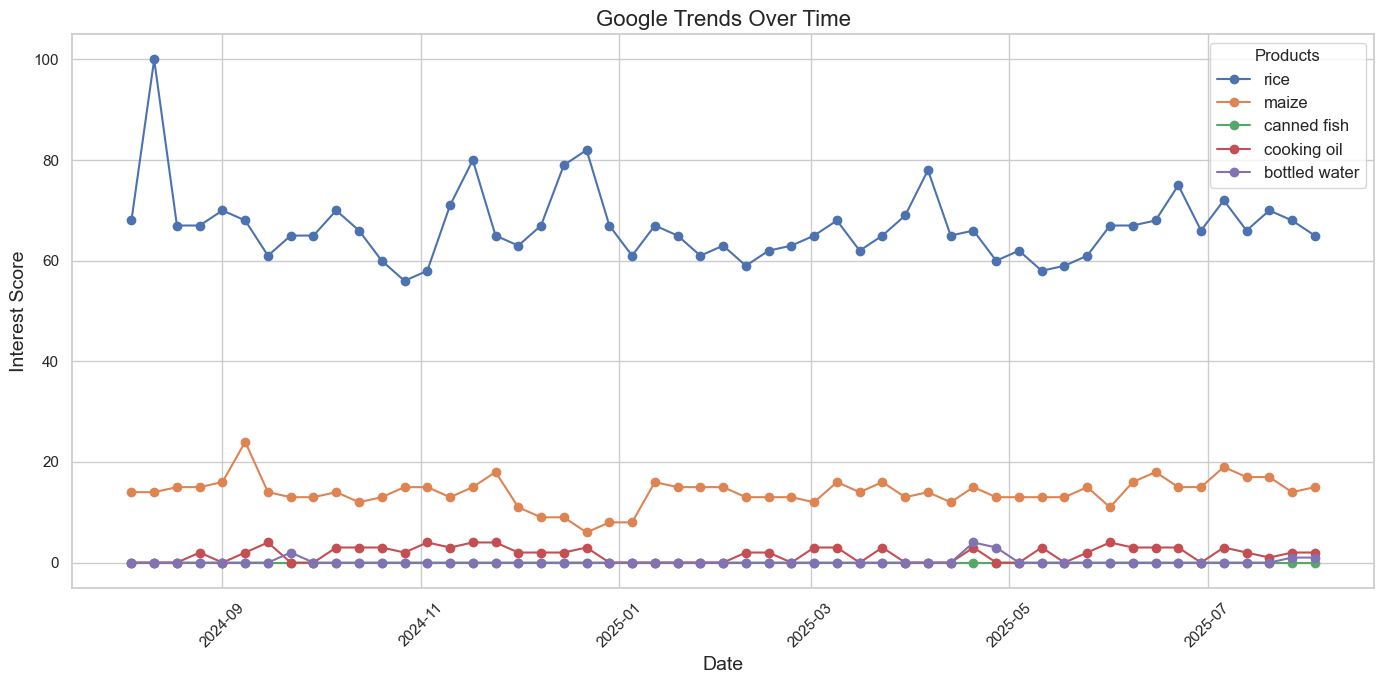

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

if trends is not None:
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))
    for col in trends.columns:
        plt.plot(trends.index, trends[col], marker="o", label=col)
    plt.title("Google Trends Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Interest Score", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Products", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No Google Trends data available.")

In [52]:
# Save the data to CSV for reproducibility and sharing
df_pop.to_csv("../data/ghana_population.csv", index=False)
df_climate.to_csv("../data/ghana_climate.csv", index=False)
if trends is not None:
    trends.to_csv("../data/ghana_product_trends.csv")
else:
    product_trends.to_csv("../data/ghana_product_trends.csv", index=False)
print("All data saved to CSV files in the current directory.")

All data saved to CSV files in the current directory.


## 5. Machine Learning Approach

We use real product trend data (from Google Trends) along with additional features (season and region) to train a regression model. The steps include:

1. Prepare the dataset by melting the trends data into a long format.
2. Add simulated region and season features.
3. Train a Random Forest regressor to predict demand.
4. Evaluate the model.


In [53]:
# Load product trends data and prepare dataset for ML
import pandas as pd
import numpy as np

trends_df = pd.read_csv("../data/ghana_product_trends.csv", parse_dates=["date"])
trends_long = trends_df.melt(
    id_vars=["date"], var_name="product", value_name="trend_score"
)


# Helper functions


# Add region and season features
def assign_region(date):
    # Alternate weeks between Accra and Tamale for demo purposes
    return "Accra" if date.week % 2 == 0 else "Tamale"


def assign_quarter(date):
    month = date.month
    if month in [1, 2, 3]:
        return "Q1"
    if month in [4, 5, 6]:
        return "Q2"
    if month in [7, 8, 9]:
        return "Q3"
    return "Q4"


trends_long["region"] = trends_long["date"].apply(assign_region)
trends_long["quarter"] = trends_long["date"].apply(assign_quarter)

print(trends_long.shape)
trends_long.head()

(265, 5)


,date,product,trend_score,region,quarter
0,2024-08-04,rice,68,Tamale,Q3
1,2024-08-11,rice,100,Accra,Q3
2,2024-08-18,rice,67,Tamale,Q3
3,2024-08-25,rice,67,Accra,Q3
4,2024-09-01,rice,70,Tamale,Q3


In [54]:
# Train a Random Forest regressor to predict trend_score using region, quarter, and product as features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le_region = LabelEncoder()
le_quarter = LabelEncoder()
le_product = LabelEncoder()

trends_long["region_enc"] = le_region.fit_transform(trends_long["region"])
trends_long["quarter_enc"] = le_quarter.fit_transform(trends_long["quarter"])
trends_long["product_enc"] = le_product.fit_transform(trends_long["product"])

# Features and target
X = trends_long[["region_enc", "quarter_enc", "product_enc"]]
y = trends_long["trend_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
print(f"Random Forest R^2 on test set: {score:.2f}")

Random Forest R^2 on test set: 0.97


In [55]:
# Use the trained model to recommend top products for Accra and Tamale in Q2 and Q4


def recommend_ml(region, quarter, top_n=5):
    region_enc = le_region.transform([region.title()])[0]
    quarter_enc = le_quarter.transform([quarter.upper()])[0]
    products = le_product.classes_
    product_encs = le_product.transform(products)
    X_pred = pd.DataFrame(
        {
            "region_enc": region_enc,
            "quarter_enc": quarter_enc,
            "product_enc": product_encs,
        }
    )
    preds = rf.predict(X_pred)
    top_idx = np.argsort(preds)[::-1][:top_n]
    return [(products[i], preds[i]) for i in top_idx]


for region in ["Accra", "Tamale"]:
    for quarter in ["Q2", "Q4"]:
        recs = recommend_ml(region, quarter)
        print(f"[ML] Top products for {region} in {quarter}:")
        for prod, score in recs:
            print(f"  {prod}: predicted demand {score:.1f}")

[ML] Top products for Accra in Q2:
  rice: predicted demand 66.8
  maize: predicted demand 14.7
  cooking oil: predicted demand 1.2
  bottled water: predicted demand 0.8
  canned fish: predicted demand 0.0
[ML] Top products for Accra in Q4:
  rice: predicted demand 62.1
  maize: predicted demand 11.7
  cooking oil: predicted demand 2.6
  bottled water: predicted demand 0.0
  canned fish: predicted demand 0.0
[ML] Top products for Tamale in Q2:
  rice: predicted demand 62.2
  maize: predicted demand 13.6
  cooking oil: predicted demand 1.9
  bottled water: predicted demand 0.4
  canned fish: predicted demand 0.0
[ML] Top products for Tamale in Q4:
  rice: predicted demand 68.4
  maize: predicted demand 13.1
  cooking oil: predicted demand 2.4
  canned fish: predicted demand 0.0
  bottled water: predicted demand 0.0


## 6. Market Demand & Data-driven Recommendations

Using simulated market demand data, the following cell recommends top product categories for Accra and Tamale based on a data-driven strategy.


In [56]:
# Simulate market demand for product categories by town and quarter
product_demand = pd.DataFrame(
    [
        {"Town": "Accra", "Quarter": "Q4", "Product": "Rice", "Demand": 95},
        {"Town": "Accra", "Quarter": "Q4", "Product": "Canned Fish", "Demand": 90},
        {"Town": "Accra", "Quarter": "Q4", "Product": "Cooking Oil", "Demand": 85},
        {"Town": "Accra", "Quarter": "Q4", "Product": "Beverages", "Demand": 80},
        {"Town": "Accra", "Quarter": "Q4", "Product": "Toiletries", "Demand": 75},
        {"Town": "Accra", "Quarter": "Q2", "Product": "Rice", "Demand": 80},
        {"Town": "Accra", "Quarter": "Q2", "Product": "Bottled Water", "Demand": 85},
        {"Town": "Accra", "Quarter": "Q2", "Product": "Cooking Oil", "Demand": 75},
        {"Town": "Accra", "Quarter": "Q2", "Product": "Fresh Produce", "Demand": 70},
        {"Town": "Tamale", "Quarter": "Q4", "Product": "Rice", "Demand": 85},
        {"Town": "Tamale", "Quarter": "Q4", "Product": "Canned Fish", "Demand": 80},
        {"Town": "Tamale", "Quarter": "Q4", "Product": "Cooking Oil", "Demand": 75},
        {"Town": "Tamale", "Quarter": "Q4", "Product": "Maize", "Demand": 90},
        {"Town": "Tamale", "Quarter": "Q2", "Product": "Maize", "Demand": 95},
        {"Town": "Tamale", "Quarter": "Q2", "Product": "Local Grains", "Demand": 90},
        {"Town": "Tamale", "Quarter": "Q2", "Product": "Cooking Oil", "Demand": 80},
        {"Town": "Tamale", "Quarter": "Q2", "Product": "Bottled Water", "Demand": 85},
    ]
)
product_demand

,Town,Quarter,Product,Demand
0,Accra,Q4,Rice,95
1,Accra,Q4,Canned Fish,90
2,Accra,Q4,Cooking Oil,85
3,Accra,Q4,Beverages,80
4,Accra,Q4,Toiletries,75
5,Accra,Q2,Rice,80
6,Accra,Q2,Bottled Water,85
7,Accra,Q2,Cooking Oil,75
8,Accra,Q2,Fresh Produce,70
9,Tamale,Q4,Rice,85


In [57]:
def recommend_products_data_driven(town: str, quarter: str, top_n: int = 5):
    df_filtered = product_demand[
        (product_demand["Town"].str.lower() == town.lower())
        & (product_demand["Quarter"].str.upper() == quarter.upper())
    ]
    top_products = (
        df_filtered.sort_values("Demand", ascending=False)
        .head(top_n)["Product"]
        .tolist()
    )
    return top_products


# Example usage
for town in ["Accra", "Tamale"]:
    for quarter in ["Q2", "Q4"]:
        products = recommend_products_data_driven(town, quarter)
        print(
            f"[Data-driven] In {town}, recommended products for {quarter}: {', '.join(products)}"
        )

[Data-driven] In Accra, recommended products for Q2: Bottled Water, Rice, Cooking Oil, Fresh Produce
[Data-driven] In Accra, recommended products for Q4: Rice, Canned Fish, Cooking Oil, Beverages, Toiletries
[Data-driven] In Tamale, recommended products for Q2: Maize, Local Grains, Bottled Water, Cooking Oil
[Data-driven] In Tamale, recommended products for Q4: Maize, Rice, Canned Fish, Cooking Oil


In [58]:
from typing import List


def recommend_products(town: str, quarter: str) -> List[str]:
    town = town.lower()
    quarter = quarter.upper()
    if town == "accra":
        if quarter == "Q4":
            return ["Rice", "Canned Fish", "Cooking Oil", "Beverages", "Toiletries"]
        else:
            return ["Rice", "Bottled Water", "Cooking Oil", "Fresh Produce"]
    elif town == "tamale":
        if quarter in ["Q2", "Q3"]:
            return ["Maize", "Local Grains", "Cooking Oil", "Bottled Water"]
        elif quarter == "Q4":
            return ["Rice", "Canned Fish", "Cooking Oil", "Maize"]
        else:
            return ["Maize", "Local Grains", "Cooking Oil"]
    else:
        return ["Rice", "Cooking Oil"]  # Default fallback


# Sample Output
for town in ["Accra", "Tamale"]:
    for quarter in ["Q2", "Q4"]:
        products = recommend_products(town, quarter)
        print(f"In {town}, recommended products for {quarter}: {', '.join(products)}")

In Accra, recommended products for Q2: Rice, Bottled Water, Cooking Oil, Fresh Produce
In Accra, recommended products for Q4: Rice, Canned Fish, Cooking Oil, Beverages, Toiletries
In Tamale, recommended products for Q2: Maize, Local Grains, Cooking Oil, Bottled Water
In Tamale, recommended products for Q4: Rice, Canned Fish, Cooking Oil, Maize


In [59]:
if __name__ == "__main__":
    town = input("Enter town (Accra/Tamale): ")
    quarter = input("Enter quarter (Q1/Q2/Q3/Q4): ")
    ml_recs = recommend_ml(town, quarter)
    print(f"[ML] Recommended products for {town.title()} in {quarter.upper()}:")
    for product, score in ml_recs:
        print(f"  {product}: predicted demand {score:.1f}")

[ML] Recommended products for Accra in Q2:
  rice: predicted demand 66.8
  maize: predicted demand 14.7
  cooking oil: predicted demand 1.2
  bottled water: predicted demand 0.8
  canned fish: predicted demand 0.0


## 7. Limitations & Future Extensions

**Limitations:**

- Data is simulated and may not represent actual market conditions.
- Google Trends data is normalized (0–100 scale) and represents search interest, not actual purchases.
- The current logic does not break down recommendations by city details beyond town-level.

**Future Extensions:**

- Integrate real-time sales.
- Develop more advanced ML models.
- Enhance explainability and incorporate additional market factors.

**Suggestion:**

Integrate with WhatsApp using Azure Bot Service and Azure Communication Services to send recommendation results directly via WhatsApp. Azure Machine learning studio allows integration with Twilio as well, and it can easily be monitored. an alternative to Azure would be **Amazon SageMaker**.

both these services are paid.
